### Подключение библиотек и скриптов

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from lightgbm import LGBMClassifier

from src.metrics import precision_at_k
from src.utils import prefilter_items, extend_user_item_new_features, get_important_features, get_final_recomendations
from src.recommenders import MainRecommender

from tqdm import tqdm
tqdm.pandas()

### Загрузка данных

In [74]:
data = pd.read_csv('retail_train.csv')
data_test = pd.read_csv('retail_test.csv')

item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

In [75]:
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39000,364,-0.60000,1631,1,0.00000,0.00000
1,2375,26984851472,1,1033142,1,0.82000,364,0.00000,1631,1,0.00000,0.00000
2,2375,26984851472,1,1036325,1,0.99000,364,-0.30000,1631,1,0.00000,0.00000
3,2375,26984851472,1,1082185,1,1.21000,364,0.00000,1631,1,0.00000,0.00000
4,2375,26984851472,1,8160430,1,1.50000,364,-0.39000,1631,1,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00000,3262,-1.15000,1231,95,0.00000,0.00000
2396800,1001,41655829421,663,13217063,1,1.69000,3131,0.00000,2231,95,0.00000,0.00000
2396801,1001,41655829421,663,13217800,1,1.69000,3131,0.00000,2231,95,0.00000,0.00000
2396802,1167,41656790510,663,6410462,22451,43.98000,3385,-0.65000,1059,95,0.00000,0.00000


In [76]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [77]:
N=150 

VAL_SIZE = 5

train_1 = data[data['week_no'] < data['week_no'].max() - (VAL_SIZE)]
val = data[data['week_no'] >= data['week_no'].max() - (VAL_SIZE)]

train_2 = val.copy()

### Первый уровень

In [78]:
n_items_before = train_1['item_id'].nunique()
train_1 = prefilter_items(train_1, item_features=item_features, take_n_popular = 777)
n_items_after = train_1['item_id'].nunique()

print(f'Decreased # items from {n_items_before} to {n_items_after}')

Decreased # items from 85828 to 778


In [79]:
recommender = MainRecommender(train_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

In [80]:
items_emb_df = recommender.items_emb_df
users_emb_df = recommender.users_emb_df

In [81]:
train = extend_user_item_new_features(train_2, train_1, recommender, item_features, user_features, items_emb_df, users_emb_df, N)
train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc_x,coupon_match_disc,price,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,coupon_disc_y,sales_count_per_dep,qnt_of_sales_per_item_per_dep_per_week,quantity_of_sales,sales_count_per_week,qnt_of_sales_per_sub_commodity_desc,qnt_of_sales_per_item_per_sub_commodity_desc_per_week,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,mean_time,age,income,children,avr_bask,sum_per_week,count_purchases_week_mean,sum_purchases_week_mean,target
0,843,40955282722,622,845193,3,5.37000,364,-1.50000,19,90,0.00000,0.00000,1.79000,999999999,GROCERY,National,FROZEN PIZZA,SNACKS/APPETIZERS,10.5 OZ,-0.00733,0.00518,-0.01244,-0.00033,0.01008,0.00266,0.00572,-0.00712,0.00875,-0.00761,0.00312,0.01145,0.00434,0.01118,-0.00113,0.00745,0.01059,0.00157,-0.00051,0.00275,0.00000,112255,0.13731,52,8.66667,893,0.14620,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00247,0.01353,1.00000
1,843,40955282722,622,845193,3,5.37000,364,-1.50000,19,90,0.00000,0.00000,1.79000,999999999,GROCERY,National,FROZEN PIZZA,SNACKS/APPETIZERS,10.5 OZ,-0.00733,0.00518,-0.01244,-0.00033,0.01008,0.00266,0.00572,-0.00712,0.00875,-0.00761,0.00312,0.01145,0.00434,0.01118,-0.00113,0.00745,0.01059,0.00157,-0.00051,0.00275,0.00000,112255,0.13731,52,8.66667,893,0.14620,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00247,0.01353,1.00000
2,843,40955282722,622,865891,2,2.00000,364,0.00000,19,90,0.00000,0.00000,1.00000,608,GROCERY,National,FRZN MEAT/MEAT DINNERS,SS ECONOMY ENTREES/DINNERS ALL,6.75 OZ,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,112255,0.13731,25,4.16667,1105,0.14221,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00215,0.00807,0.00000
3,843,40955282722,622,883404,2,1.76000,364,-0.82000,19,90,0.00000,0.00000,0.88000,69,GROCERY,Private,BAKED BREAD/BUNS/ROLLS,MAINSTREAM WHITE BREAD,20 OZ,0.00097,0.01332,0.00376,0.01016,0.00290,-0.00806,0.00328,0.00463,-0.00668,0.00381,0.00410,0.00351,0.00364,0.00427,-0.00108,0.00126,0.00634,0.00925,-0.00593,-0.00329,0.00000,112255,0.13731,518,86.33333,1811,0.15639,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00192,0.00310,0.00000
4,843,40955282722,622,904375,4,4.00000,364,0.00000,19,90,0.00000,0.00000,1.00000,608,GROCERY,National,FRZN MEAT/MEAT DINNERS,SS ECONOMY ENTREES/DINNERS ALL,7.5 OZ,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,112255,0.13731,24,4.00000,1105,0.14221,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00215,0.00807,0.00000


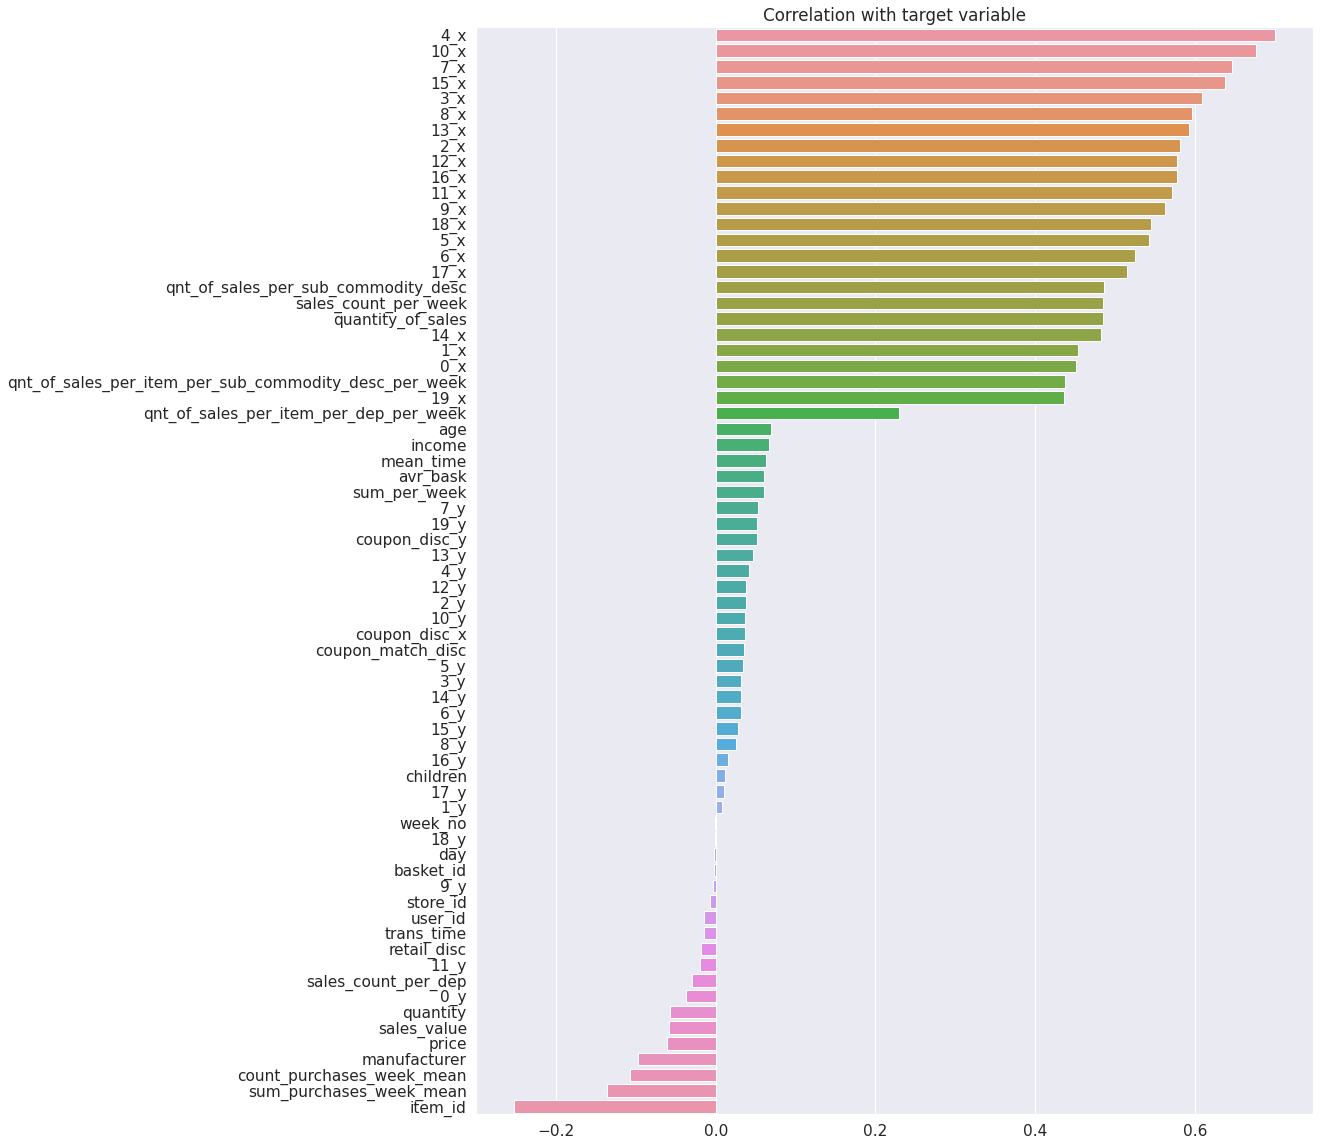

In [82]:
TARGET_NAME = 'target'

corr_with_target = train.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

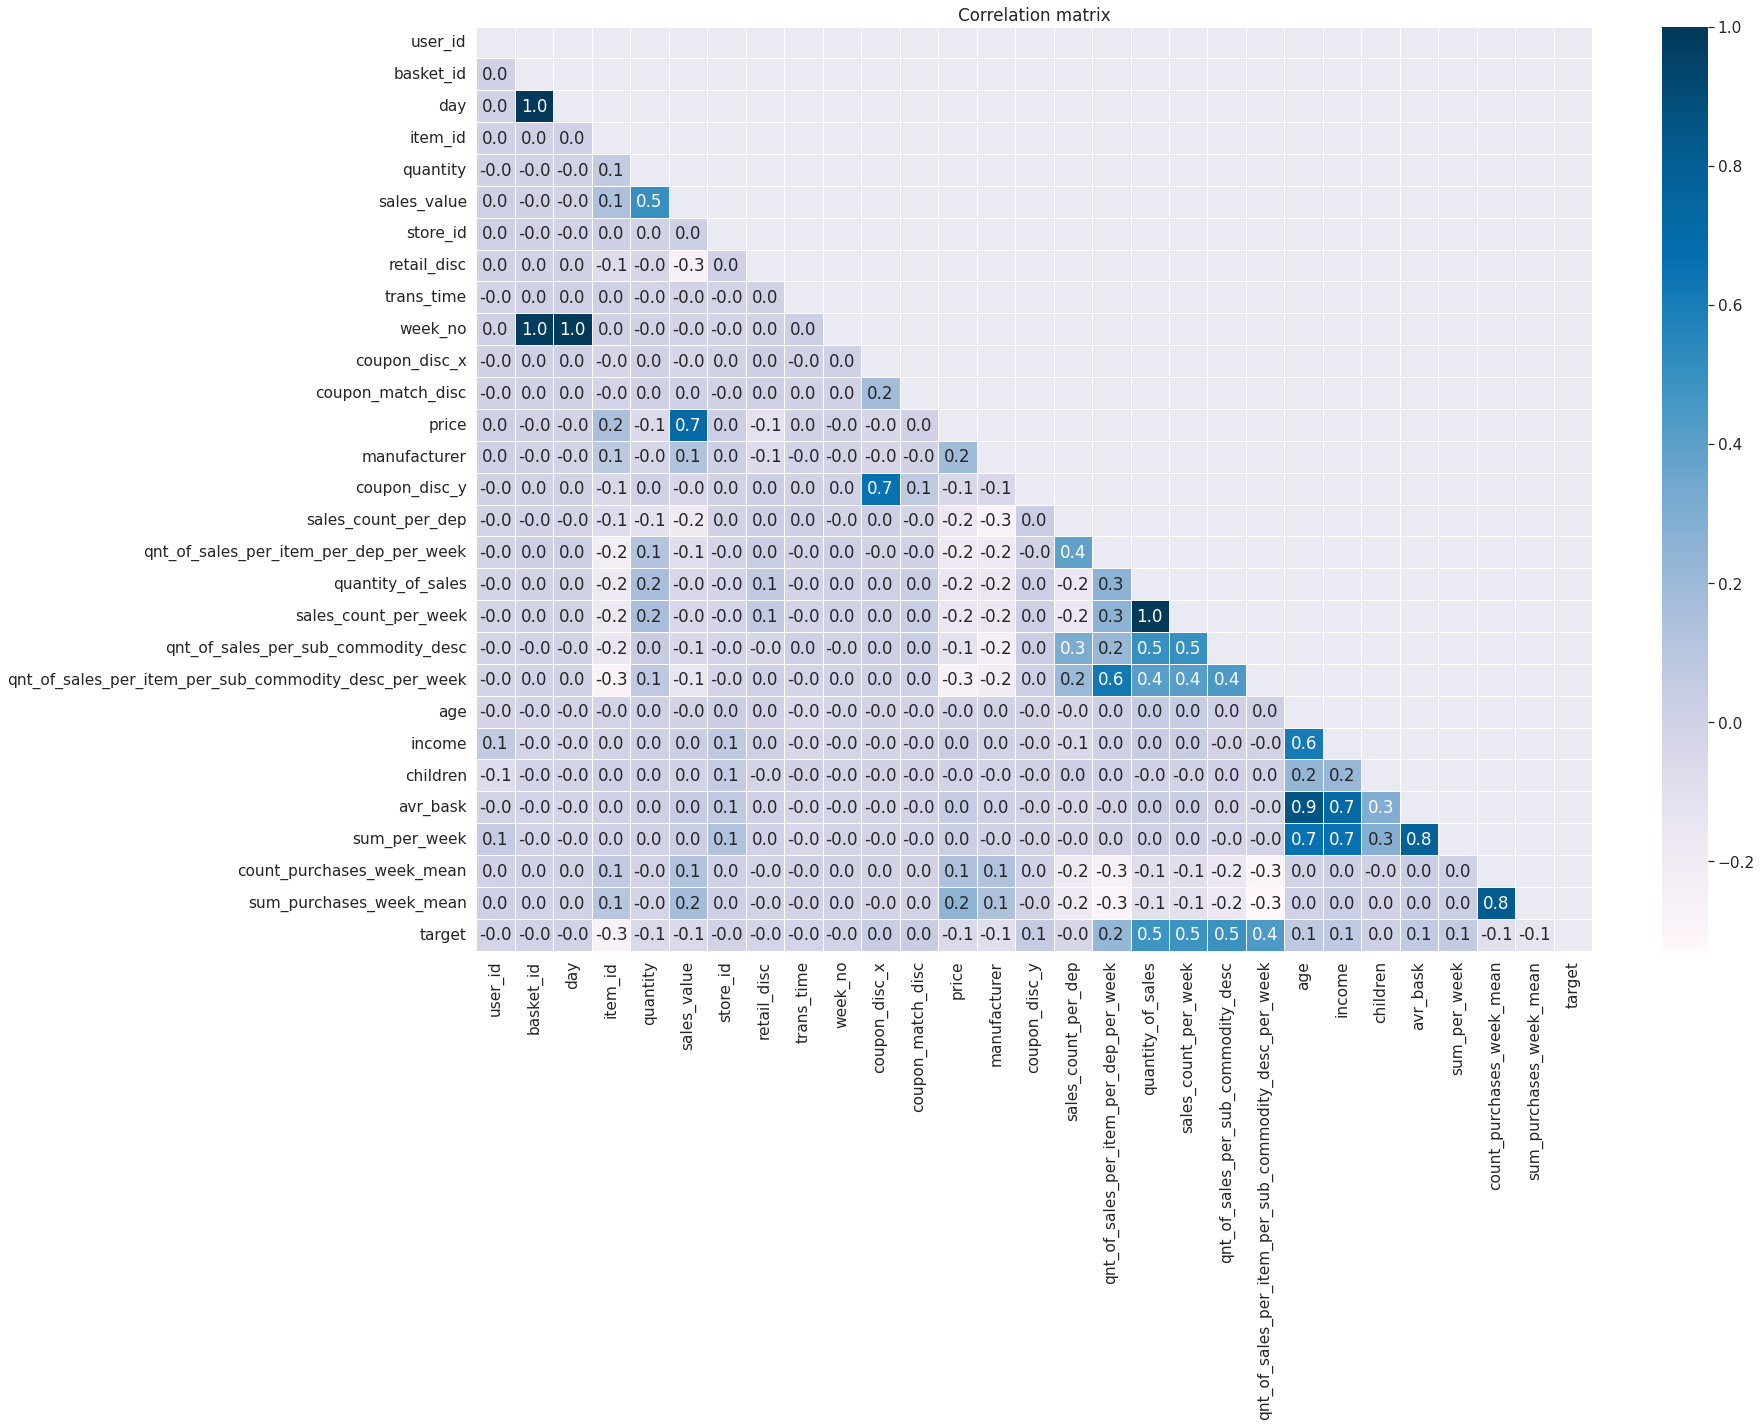

In [83]:
df_num_features = train.select_dtypes(include = ['float64', 'int64'])
num_features = pd.DataFrame(df_num_features)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix')
plt.show()

In [84]:
X_train = train.drop(['target'], axis=1)
y_train = train[['target']]

In [85]:
cat_features=[]
for col in X_train.columns:
    if(X_train[col].dtype == np.object):
          cat_features.append(col)
            
X_train[cat_features + ['user_id', 'item_id']] = X_train[cat_features + ['user_id', 'item_id']].astype('category')

In [86]:
cat_features

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc']

In [87]:
test = extend_user_item_new_features(data_test, train_1, recommender, item_features, user_features, items_emb_df, users_emb_df, N)
X_test = test.drop(['target'], axis=1)
y_test = test[['target']]
X_test[cat_features + ['user_id', 'item_id']] = X_test[cat_features + ['user_id', 'item_id']].astype('category')

### Второй уровень

In [88]:
lgbc = LGBMClassifier(objective='binary', max_depth=4, categorical_column=cat_features)

In [89]:
important_features = get_important_features(lgbc, X_train, y_train)
important_features

['user_id',
 'basket_id',
 'item_id',
 'quantity',
 'sales_value',
 'store_id',
 'retail_disc',
 'trans_time',
 'price',
 'manufacturer',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 '0_x',
 '1_x',
 '2_x',
 '3_x',
 '4_x',
 '5_x',
 '6_x',
 '7_x',
 '8_x',
 '9_x',
 '10_x',
 '11_x',
 '12_x',
 '13_x',
 '14_x',
 '15_x',
 '16_x',
 '17_x',
 '18_x',
 '19_x',
 'coupon_disc_y',
 'sales_count_per_dep',
 'qnt_of_sales_per_item_per_dep_per_week',
 'quantity_of_sales',
 'qnt_of_sales_per_sub_commodity_desc',
 'qnt_of_sales_per_item_per_sub_commodity_desc_per_week',
 '0_y',
 '1_y',
 '2_y',
 '3_y',
 '4_y',
 '5_y',
 '6_y',
 '7_y',
 '8_y',
 '9_y',
 '10_y',
 '11_y',
 '12_y',
 '13_y',
 '14_y',
 '15_y',
 '16_y',
 '17_y',
 '18_y',
 '19_y',
 'mean_time',
 'income',
 'sum_per_week',
 'count_purchases_week_mean',
 'sum_purchases_week_mean']

In [90]:
lgbc.fit(X_train[important_features], y_train)

LGBMClassifier(categorical_column=['department', 'brand', 'commodity_desc',
                                   'sub_commodity_desc', 'curr_size_of_product',
                                   'marital_status_code', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc'],
               max_depth=4, objective='binary')

In [91]:
test_preds_proba = lgbc.predict_proba(X_test[important_features])[:, 1]

In [92]:
result = get_final_recomendations(X_test, test_preds_proba, data, train_1, item_features)

100%|██████████| 2499/2499 [07:20<00:00,  5.67it/s]


In [93]:
final_result = result.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

In [94]:
final_result

0.5054821928771509

In [95]:
result.drop('actual', axis=1, inplace=True)

In [96]:
result.to_csv('recommendations.csv', index=False)